In [1]:
# Preprocesamiento de Datos
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# Modelado con TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Procesamiento de Imágenes
import cv2

# Guardado y Carga de Modelos
import joblib
import os

# Otros Recursos Útiles
import random

In [2]:
# Rutas de Datos
ruta_train_csv = r'C:\Users\mikel\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\train.csv'
ruta_test_csv = r'C:\Users\mikel\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\test.csv'
ruta_train_img = r'C:\Users\mikel\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\train'
ruta_test_img = r'C:\Users\mikel\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\test'

# Cargar Datos
df_train = pd.read_csv(ruta_train_csv)
df_test = pd.read_csv(ruta_test_csv)

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   id          15000 non-null  int64
 1   clip_count  15000 non-null  int64
dtypes: int64(2)
memory usage: 234.5 KB


In [4]:
df_train.describe()

,id,clip_count
count,15000.000000,15000.000000
mean,37500.500000,37.290133
std,4330.271354,21.922691
min,30001.000000,0.000000
25%,33750.750000,18.000000
50%,37500.500000,37.000000
75%,41250.250000,56.000000
max,45000.000000,75.000000


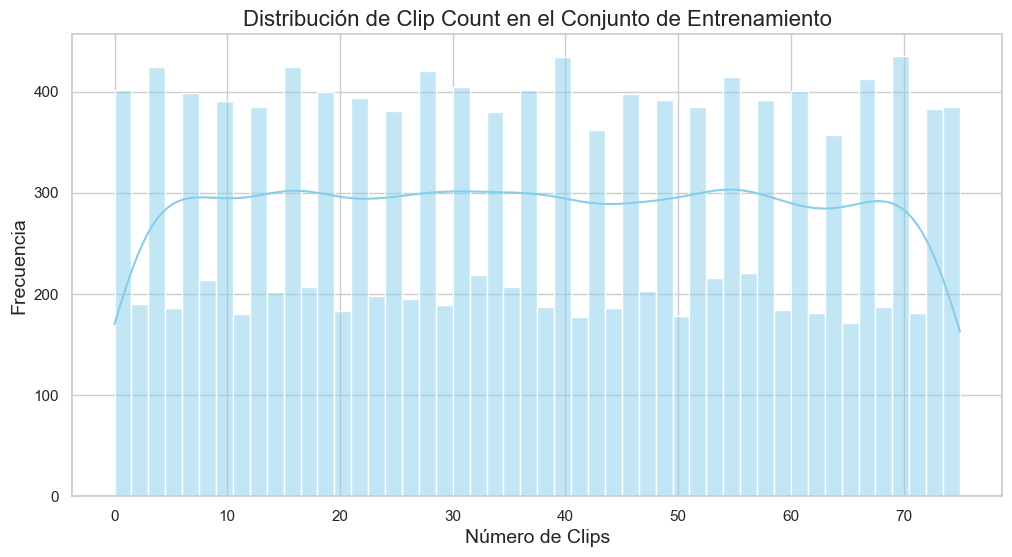

In [5]:
# Configurar estilo de Seaborn
sns.set(style="whitegrid")

# Histograma de la columna clip_count
plt.figure(figsize=(12, 6))
sns.histplot(df_train['clip_count'], bins=50, kde=True, color='skyblue')

# Añadir detalles al gráfico
plt.title('Distribución de Clip Count en el Conjunto de Entrenamiento', fontsize=16)
plt.xlabel('Número de Clips', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)

# Mostrar el gráfico
plt.show()

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      5000 non-null   int64
dtypes: int64(1)
memory usage: 39.2 KB


In [7]:
df_test.describe()

,id
count,5000.000000
mean,47500.500000
std,1443.520003
min,45001.000000
25%,46250.750000
50%,47500.500000
75%,48750.250000
max,50000.000000


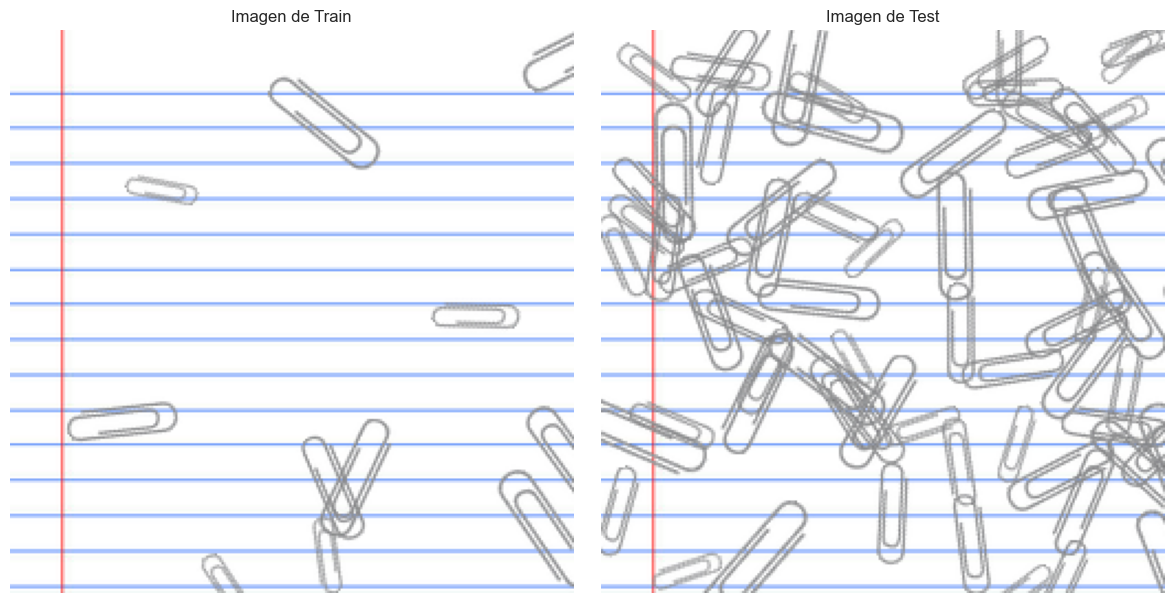

In [8]:
# Función para mostrar una imagen
def mostrar_imagen(ruta_img, img_id, titulo):
    img_path = os.path.join(ruta_img, f"clips-{img_id}.png")
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"No se pudo cargar la imagen: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(titulo)
    plt.axis('off')

# Visualizar imágenes de train y test
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Imagen de train
plt.subplot(1, 2, 1)
mostrar_imagen(ruta_train_img, img_id='30001', titulo='Imagen de Train')

# Imagen de test
plt.subplot(1, 2, 2)
mostrar_imagen(ruta_test_img, img_id='45001', titulo='Imagen de Test')

plt.tight_layout()
plt.show()

In [9]:
# Función para obtener información de una imagen
def obtener_info_imagen(ruta_img, img_id):
    img_path = os.path.join(ruta_img, f"clips-{img_id}.png")
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"No se pudo cargar la imagen: {img_path}")
    
    # Tipo de archivo
    extension = os.path.splitext(img_path)[-1]
    
    # Dimensiones de la imagen
    altura, anchura = img.shape[:2]
    
    # Tipo de color
    if len(img.shape) == 3:
        canales = img.shape[2]
        tipo_color = "Color (RGB)" if canales == 3 else "Escala de Grises con Alfa"
    else:
        tipo_color = "Escala de Grises"
    
    # Mostrar resultados
    print(f"Información de la imagen: {img_path}")
    print(f"- Dimensiones: {anchura} x {altura}")
    print(f"- Tipo de archivo: {extension}")
    print(f"- Tipo de color: {tipo_color}")

# Mostrar información de una imagen de entrenamiento y una de prueba
print("Imagen de Entrenamiento:")
obtener_info_imagen(ruta_train_img, img_id='30001')

print("\nImagen de Prueba:")
obtener_info_imagen(ruta_test_img, img_id='45001')

Imagen de Entrenamiento:
Información de la imagen: C:\Users\mikel\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\train\clips-30001.png
- Dimensiones: 256 x 256
- Tipo de archivo: .png
- Tipo de color: Color (RGB)

Imagen de Prueba:
Información de la imagen: C:\Users\mikel\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\test\clips-45001.png
- Dimensiones: 256 x 256
- Tipo de archivo: .png
- Tipo de color: Color (RGB)


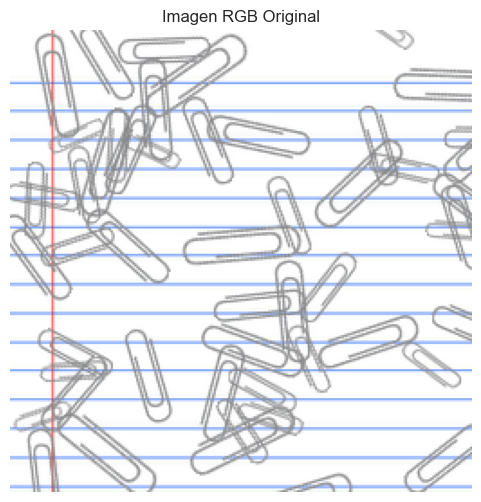

In [10]:
# Cargar la imagen
ruta_img = r'C:\Users\mikel\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\train\clips-30007.png'
img = cv2.imread(ruta_img)

if img is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen en la ruta: {ruta_img}")

# Convertir de BGR a RGB para visualización
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Mostrar la imagen original
plt.figure(figsize=(6, 6))
plt.title('Imagen RGB Original')
plt.axis('off')
plt.imshow(rgb)
plt.show()

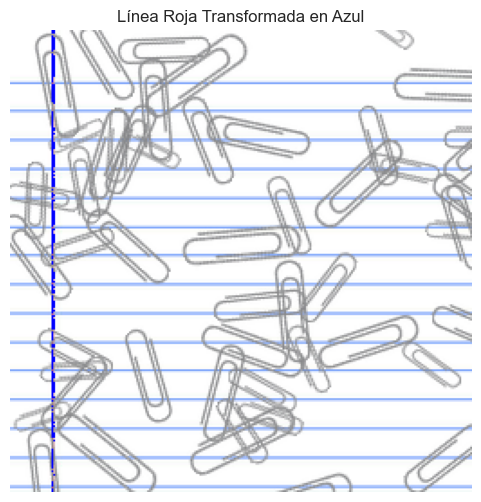

In [11]:
# Convertir a HSV para una manipulación de color más precisa
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Detectar la línea roja
mask_roja1 = cv2.inRange(hsv, (0, 50, 50), (10, 255, 255))   # Rango para rojo (parte 1)
mask_roja2 = cv2.inRange(hsv, (170, 50, 50), (180, 255, 255)) # Rango para rojo (parte 2)
mask_roja = cv2.bitwise_or(mask_roja1, mask_roja2)

# Transformar la línea roja a azul (mismo tono de las líneas horizontales)
img[mask_roja > 0] = (255, 0, 0)  # Azul en formato BGR

# Mostrar la imagen con la línea roja transformada en azul
plt.figure(figsize=(6, 6))
plt.title('Línea Roja Transformada en Azul')
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

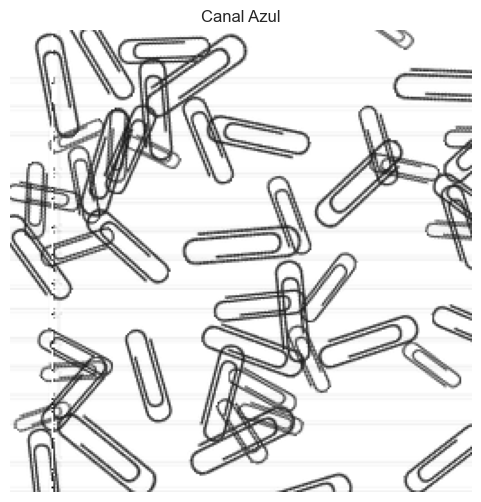

In [12]:
import numpy as np

# Extraer el canal azul
b, g, r = cv2.split(img)

# Mostrar el canal azul
plt.figure(figsize=(6, 6))
plt.title('Canal Azul')
plt.axis('off')
plt.imshow(b, cmap='gray')
plt.show()

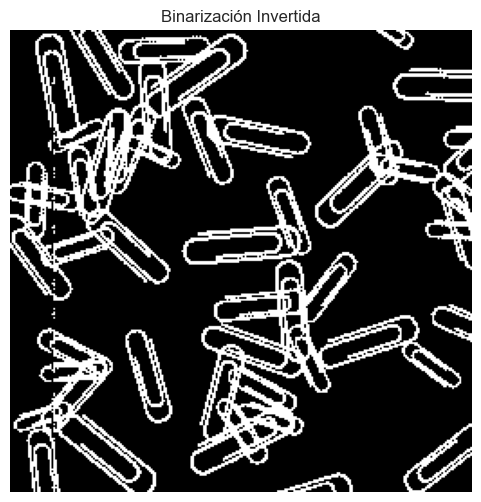

In [13]:
# Aplicar binarización directa
_, thresh = cv2.threshold(b, 225, 255, cv2.THRESH_BINARY)

# Invertir la imagen binarizada
thresh_invertida = 255 - thresh

# Mostrar la binarización invertida
plt.figure(figsize=(6, 6))
plt.title('Binarización Invertida')
plt.axis('off')
plt.imshow(thresh_invertida, cmap='gray')
plt.show()

In [14]:
def transformar_imagen(ruta):
    # Cargar la imagen
    img = cv2.imread(ruta)
    if img is None:
        raise FileNotFoundError(f"No se pudo cargar la imagen en la ruta: {ruta}")
    
    # Convertir a HSV
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Detectar la línea roja y transformarla en azul
    mask_roja1 = cv2.inRange(img_hsv, (0, 50, 50), (10, 255, 255))   # Rojo parte 1
    mask_roja2 = cv2.inRange(img_hsv, (170, 50, 50), (180, 255, 255)) # Rojo parte 2
    mask_roja = cv2.bitwise_or(mask_roja1, mask_roja2)
    img[mask_roja > 0] = (255, 0, 0)  # Azul en formato BGR
    
    # Extraer el canal azul
    b = img[:, :, 0]  # Solo el canal azul
    
    # Binarización directa
    _, thresh = cv2.threshold(b, 225, 255, cv2.THRESH_BINARY)
    
    # Invertir la imagen binarizada
    thresh_invertida = 255 - thresh
    
    # Redimensionar y normalizar
    img_final = cv2.resize(thresh_invertida, (256, 256))
    img_final = img_final.astype(np.float32) / 255.0  # Normalizar a float32
    
    return img_final

In [15]:
# Cargar y transformar imágenes de entrenamiento
X = []
y = []

for index, row in df_train.iterrows():
    ruta_img = os.path.join(ruta_train_img, f"clips-{row['id']}.png")
    if os.path.exists(ruta_img):
        img = transformar_imagen(ruta_img)
        X.append(img)
        y.append(row['clip_count'])

# Convertir a NumPy con float32 para optimizar memoria
X = np.array(X, dtype=np.float32).reshape(-1, 256, 256, 1)  # Añadir un canal para la CNN
y = np.array(y, dtype=np.int32)  # Usar int32 para etiquetas

# Dividir en Train y Validation
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

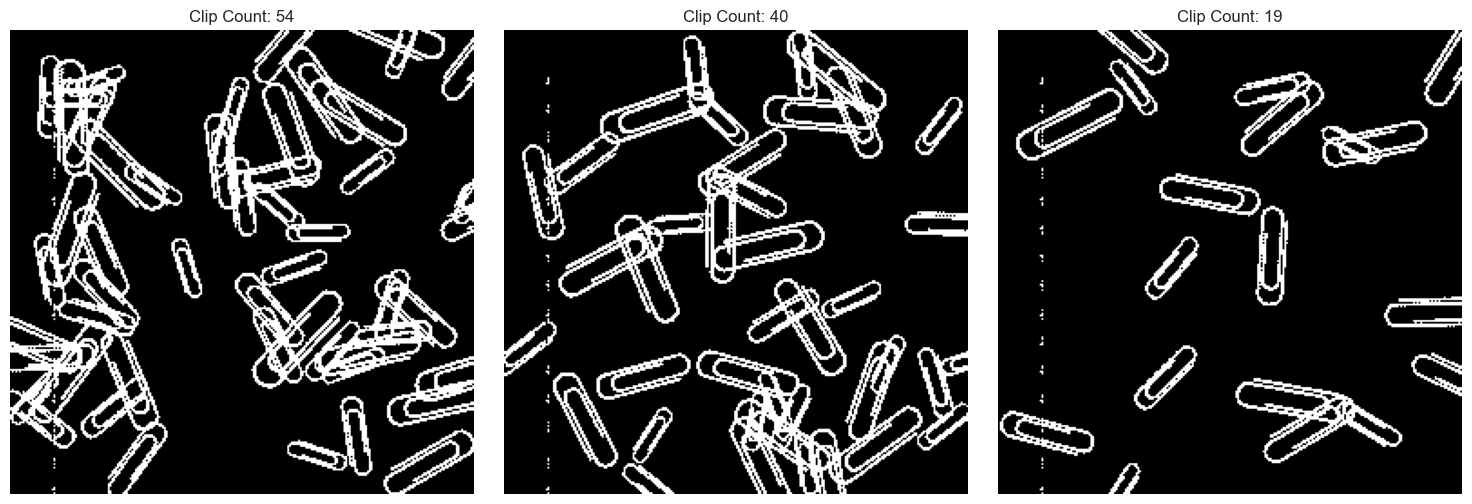

In [16]:
# Seleccionar 3 índices aleatorios
indices = random.sample(range(X_train.shape[0]), 3)

# Visualizar las imágenes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, idx in enumerate(indices):
    axes[i].imshow(X_train[idx].reshape(256, 256), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Clip Count: {y_train[idx]}')

plt.tight_layout()
plt.show()

In [17]:
# Cargar y transformar imágenes de prueba
X_test = []
ids = []

for index, row in df_test.iterrows():
    ruta_img = os.path.join(ruta_test_img, f"clips-{row['id']}.png")
    if os.path.exists(ruta_img):
        img = transformar_imagen(ruta_img)
        X_test.append(img)
        ids.append(row['id'])

# Convertir a NumPy con float32
X_test = np.array(X_test, dtype=np.float32).reshape(-1, 256, 256, 1)

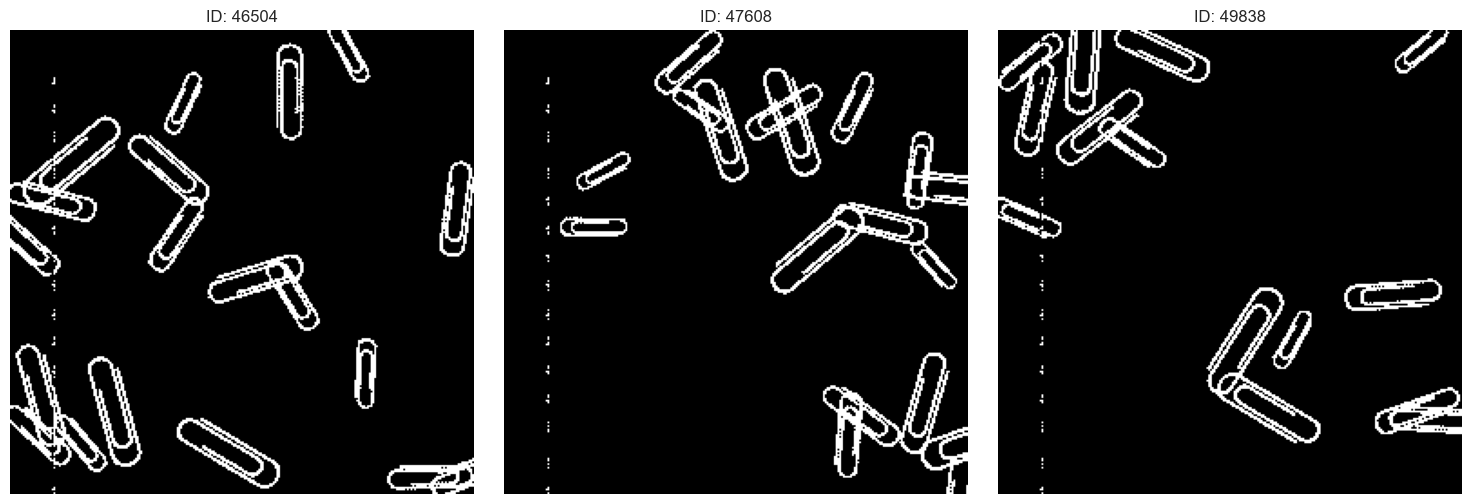

In [18]:
# Seleccionar 3 índices aleatorios
indices = random.sample(range(X_test.shape[0]), 3)

# Visualizar las imágenes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, idx in enumerate(indices):
    axes[i].imshow(X_test[idx].reshape(256, 256), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'ID: {ids[idx]}')

plt.tight_layout()
plt.show()

In [19]:
# Validar imágenes
print("Forma de X_train:", X_train.shape)
print("Rango de valores (mínimo y máximo):", X_train.min(), X_train.max())

# Validar etiquetas
print("Forma de y_train:", y_train.shape)
print("Ejemplos de y_train:", y_train[:5])

Forma de X_train: (12000, 256, 256, 1)
Rango de valores (mínimo y máximo): 0.0 1.0
Forma de y_train: (12000,)
Ejemplos de y_train: [38 75 20 18 66]


In [20]:
# Validar Imágenes de Validación
print("Forma de X_val:", X_val.shape)
print("Rango de valores en X_val (mínimo y máximo):", X_val.min(), X_val.max())

# Validar Etiquetas de Validación
print("Forma de y_val:", y_val.shape)
print("Ejemplos de y_val:", y_val[:5])

Forma de X_val: (3000, 256, 256, 1)
Rango de valores en X_val (mínimo y máximo): 0.0 1.0
Forma de y_val: (3000,)
Ejemplos de y_val: [46 17 22 45 65]


In [21]:
# Validar Imágenes de Prueba
print("Forma de X_test:", X_test.shape)
print("Rango de valores en X_test (mínimo y máximo):", X_test.min(), X_test.max())

# Validar IDs de Prueba
print("Número de IDs:", len(ids))
print("Ejemplos de IDs:", ids[:5])

Forma de X_test: (5000, 256, 256, 1)
Rango de valores en X_test (mínimo y máximo): 0.0 1.0
Número de IDs: 5000
Ejemplos de IDs: [np.int64(45001), np.int64(45002), np.int64(45003), np.int64(45004), np.int64(45005)]


In [22]:
# Modelo CNN Ultra Simple
modelo = Sequential([
    # Capa Convolucional Básica
    Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    MaxPooling2D((2, 2)),
    
    # Segunda Capa Convolucional (opcional, si no funciona bien con una)
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Aplanar y Capas Densas
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1)  # Salida para regresión (un valor)
])

# Compilar el Modelo
modelo.compile(
    optimizer=Adam(learning_rate=0.0001),  # Tasa de aprendizaje ajustada
    loss='mean_squared_error',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# Resumen del Modelo
modelo.summary()

C:\Users\mikel\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 123008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     3,936,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,941,121 (15.03 MB)

 Trainable params: 3,941,121 (15.03 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    min_delta=1e-4,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    cooldown=2,
    verbose=1
)

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True
)

In [25]:
# Entrenar el Modelo Simplificado
historial = modelo.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=6,
    callbacks=[early_stopping, reduce_lr],
    shuffle=True,
    verbose=1
)

Epoch 1/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 111s 55ms/step - loss: 70.7449 - root_mean_squared_error: 7.1790 - val_loss: 12.1584 - val_root_mean_squared_error: 3.4869 - learning_rate: 1.0000e-04
Epoch 2/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 110s 55ms/step - loss: 5.7257 - root_mean_squared_error: 2.3902 - val_loss: 5.9989 - val_root_mean_squared_error: 2.4493 - learning_rate: 1.0000e-04
Epoch 3/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 111s 55ms/step - loss: 3.9057 - root_mean_squared_error: 1.9726 - val_loss: 4.5270 - val_root_mean_squared_error: 2.1277 - learning_rate: 1.0000e-04
Epoch 4/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 110s 55ms/step - loss: 2.5868 - root_mean_squared_error: 1.6068 - val_loss: 5.1115 - val_root_mean_squared_error: 2.2609 - learning_rate: 1.0000e-04
Epoch 5/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 110s 55ms/step - loss: 2.0141 - root_mean_squared_error: 1.4182 - val_loss: 4.2281 - val_root_mean_squared_error: 2.0562 - learning_rate: 1.0000e-04
Epoch 6/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1

In [26]:
# Evaluar el Modelo
pérdida, rmse = modelo.evaluate(X_val, y_val)
print(f"🔹 RMSE en validación: {rmse}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 3.1357 - root_mean_squared_error: 1.7702
🔹 RMSE en validación: 1.7522512674331665


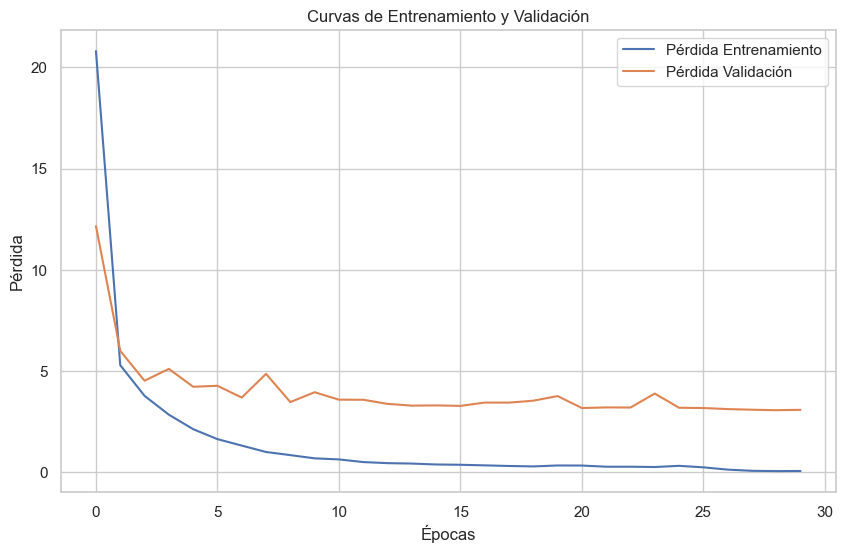

In [27]:
# Curvas de Entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(historial.history['loss'], label='Pérdida Entrenamiento')
plt.plot(historial.history['val_loss'], label='Pérdida Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Curvas de Entrenamiento y Validación')
plt.legend()
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step


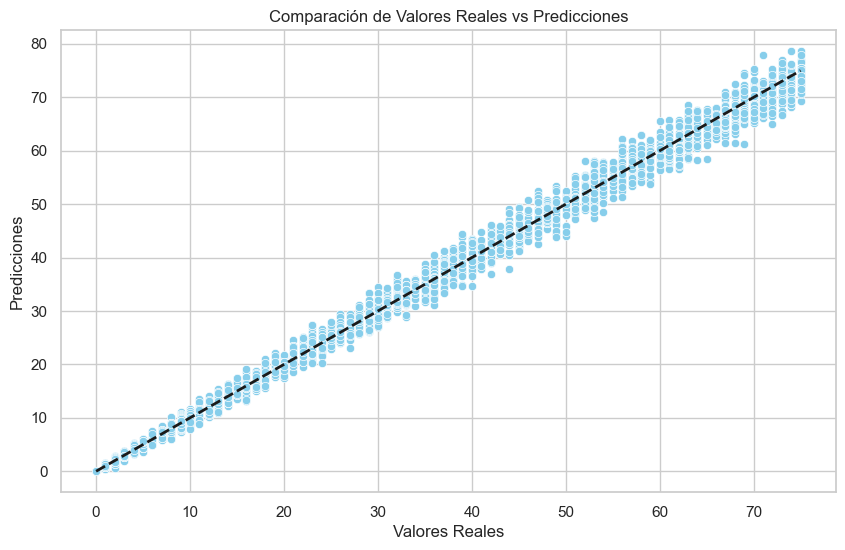

In [28]:
# Predecir en el conjunto de validación
y_pred = modelo.predict(X_val).flatten()

# Crear un DataFrame para comparar
df_resultados_val = pd.DataFrame({'Real': y_val, 'Predicción': y_pred})

# Visualizar la comparación
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_resultados_val, x='Real', y='Predicción', color='skyblue')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de Valores Reales vs Predicciones')
plt.show()


In [29]:
# Realizar Predicciones en Prueba
predicciones = modelo.predict(X_test).flatten()

# Redondear las Predicciones y Convertirlas a int64
predicciones = np.round(predicciones).astype(np.int64)

# Crear Archivo de Resultados con ids como int64
df_resultados = pd.DataFrame({
    'id': np.array(ids, dtype=np.int64),  # Asegurar que los ids sean int64
    'clip_count': predicciones           # Predicciones ya redondeadas y convertidas a int64
})

# Guardar el Archivo Final
df_resultados.to_csv('submission.csv', index=False)
print("Predicciones guardadas en submission.csv")

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step
Predicciones guardadas en submission.csv


In [30]:
# Guardar el modelo en formato .keras
modelo.save('modelo_clip_count_final.keras')

print("¡El modelo ha sido guardado correctamente en formato .keras!")

¡El modelo ha sido guardado correctamente en formato .keras!
